# TEOTIL map generation

In [2]:
import pandas.io.sql as sqlio
import psycopg2
from fabric import Connection
from tempfile import NamedTemporaryFile
import pandas as pd
import json
import seaborn as sns
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import requests
import re
from urllib.parse import urljoin
import getpass
from io import StringIO
import paramiko

#connection to the vm
key = getpass.getpass('mobiserver password: ')
cloudKey = getpass.getpass('vault password: ')

#Fetching credentials
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',
                         password=key) as db:
        with db.cursor() as cursor :
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result
            else: 
                cursor.execute(query)
  

#Setting connection to the vm
sshKey = query('''select niva.getToken('geonorway_ssh_key','{}');'''.format(cloudKey)).iloc[0,0]
not_really_a_file = StringIO(sshKey)
private_key = paramiko.RSAKey.from_private_key(not_really_a_file)
del key,sshKey
                
config =  {'host' : '34.88.18.174', 'user': 'jose-luis', 'connect_kwargs': {'pkey': private_key } }

def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='34.88.18.174', port=5432, database='geonorway',password='kakaroto') as db:
        with db.cursor() as cursor :
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result
            else: 
                cursor.execute(query)

mobiserver password:  ·······
vault password:  ···············


In [7]:
#Listing files with teotil results
baseURL = 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/'
only_a_tags = SoupStrainer("a", href=True)

s=requests.Session()

#Getting only tags with links. Only the tags containing the re_str will be included
def getSoup(url,re_str):
    request=s.get(url)
    soup=BeautifulSoup(request.text,'lxml',parse_only=only_a_tags)
    link_soup=soup.find_all('a',text=re.compile(re_str))
    links=[]
    for i in link_soup:
        links.append(urljoin(url,i['href']))
    return links

allResults = getSoup(baseURL,'teotil2_results')
allResults


['https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1990.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1991.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1992.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1993.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1994.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1995.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1996.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1997.csv',
 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_1998.csv',
 'https://github.com/NIVANorge/teotil

In [3]:
schema = 'teotil2021_rerun'

#query('''drop schema if exists {schema} cascade;
#create schema {schema};'''.format(schema=schema),fetch=False)

sql = '''drop table if exists {schema}.t_FOSFOR;
create table {schema}.t_FOSFOR(ID1 serial primary key,
VASSOMR int,
ID_Num int,
Year int,
Areal double precision,
Q double precision,
akva double precision,
jordbr double precision,
befolkn double precision,
ind double precision,
natur double precision,
sum double precision,
antrop double precision);'''
#query(sql.format(schema=schema),fetch = False)


sql = '''drop table if exists {schema}.t_NITROGEN;
create table {schema}.t_NITROGEN(ID1 serial primary key,
VASSOMR int,
ID_Num int,
Year int,
Areal double precision,
Q double precision,
akva double precision,
jordbr double precision,
befolkn double precision,
ind double precision,
natur double precision,
sum double precision,
antrop double precision);'''
#query(sql.format(schema=schema),fetch = False)


In [9]:
teotil_report_map_p = {
    'Akvakultur' : ["accum_aqu_tot-p_tonnes" ],
    'Jordbruk' : ["accum_agri_diff_tot-p_tonnes","accum_agri_pt_tot-p_tonnes"],
    'Befolkning' : ["accum_ren_tot-p_tonnes","accum_spr_tot-p_tonnes" ],
    'Industri' : ["accum_ind_tot-p_tonnes"],
    'Bakgrunn' : ["accum_nat_diff_tot-p_tonnes" ],
    'Totalt' : ["accum_all_sources_tot-p_tonnes"],
    'Menneskeskapt' : ["accum_anth_diff_tot-p_tonnes","accum_all_point_tot-p_tonnes"],    
    'Urban' :["accum_urban_tot-p_tonnes",],
    'Vannforing' :["accum_q_m3/s",]
}


teotil_report_map_n = {
    'Akvakultur' : ["accum_aqu_tot-n_tonnes" ],
    'Jordbruk' : ["accum_agri_diff_tot-n_tonnes","accum_agri_pt_tot-n_tonnes"],
    'Befolkning' : ["accum_ren_tot-n_tonnes","accum_spr_tot-n_tonnes" ],
    'Industri' : ["accum_ind_tot-n_tonnes"],
    'Bakgrunn' : ["accum_nat_diff_tot-n_tonnes" ],
    'Totalt' : ["accum_all_sources_tot-n_tonnes"],
    'Menneskeskapt' : ["accum_anth_diff_tot-n_tonnes","accum_all_point_tot-n_tonnes"],    
    'Urban' :["accum_urban_tot-n_tonnes",],
    'Vannforing' : ["accum_q_m3/s",]
}

In [29]:
with open('1990.csv','r') as f:
    header = f.readline().strip().split(',')
# # list(a.columns)
cols = ['"{}" double precision'.format(j) if i > 1 else '"{}" varchar(30)'.format(j) for i,j in enumerate(header)]

sql = '''drop table if exists {schema}.gitresults;
create table {schema}.gitresults ({columns},year int);
'''.format(schema=schema,columns=','.join(cols))

query(sql,fetch=False)
with Connection(**config) as c:
    c.run('rm -rf teotil2021 && mkdir teotil2021')
    for ii,file in enumerate(allResults):
        file = file.replace('blob','raw')
        year=int(file.split('.')[1][-4:])
        display(year)
        c.run('wget -O ./teotil2021/{}.csv {}'.format(year,file),hide='stderr')
        c.run('''psql -d geonorway -c "drop table if exists {schema}.dummy;" '''.format(schema=schema))
        query('''create table {schema}.dummy ({columns});'''.format(schema=schema,columns=','.join(cols)),fetch=False)
        c.run('''psql -d geonorway -c "\copy {schema}.dummy from './teotil2021/{year}.csv' delimiter ',' csv header" '''.format(schema=schema,year=year))
        c.run('''psql -d geonorway -c "alter table {schema}.dummy add column year int;" '''.format(schema=schema))
        c.run('''psql -d geonorway -c "update {schema}.dummy set year={year}" '''.format(schema=schema,year=year))
        c.run('''psql -d geonorway -c "insert into {schema}.gitresults select * from  {schema}.dummy" '''.format(schema=schema,year=year))
       

1990

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1991

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1992

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1993

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1994

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1995

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1996

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1997

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1998

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


1999

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2000

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2001

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2002

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2003

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2004

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2005

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2006

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2007

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2008

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2009

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2010

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2011

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2012

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2013

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2014

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2015

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2016

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2017

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2018

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2019

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


2020

DROP TABLE
COPY 20474
ALTER TABLE
UPDATE 20474
INSERT 0 20474


In [45]:
#Creating a table with fewer rows: regine, regine_ned, output id, and output. output id references a table where the output names are stored
with open('1990.csv','r') as f:
    header = f.readline().strip().split(',')
    
query('''drop table if exists {schema}.outputname cascade;
create table {schema}.outputname(oid serial primary key, outputname varchar(100));
insert into {schema}.outputname(outputname) values {columnnames};
'''.format(schema=schema,
           columnnames='('+ '),('.join(["'{}'".format(i) for i in header[2:]]) + ')'
          ), 
      fetch=False);
    
sql = '''drop table if exists {schema}.results;
create table {schema}.results as 
select regine,regine_ned,year,
unnest(array[{single_quote}]) as outputname,
unnest(array[{double_quote}]) as value
from teotil2021.gitresults
order by regine,regine_ned,year;
alter table {schema}.results add column oid int references {schema}.outputname(oid);
update {schema}.results as a set oid=(select oid from {schema}.outputname as b where a.outputname=b.outputname);
alter table {schema}.results drop column outputname;
'''.format(schema=schema,
                       single_quote=','.join(["'{}'".format(i) for i in header[2:]]),
                       double_quote=','.join(['"{}"'.format(i) for i in header[2:]]) 
                      )

query(sql,fetch=False)

# with open('sql.sql','w') as f:
#     f.write(sql)

In [83]:
#Create output for oyvind
teotil_report_map_p = {
    'Akvakultur' : ["accum_aqu_tot-p_tonnes" ],
    'Jordbruk' : ["accum_agri_diff_tot-p_tonnes","accum_agri_pt_tot-p_tonnes"],
    'Befolkning' : ["accum_ren_tot-p_tonnes","accum_spr_tot-p_tonnes" ],
    'Industri' : ["accum_ind_tot-p_tonnes"],
    'Bakgrunn' : ["accum_nat_diff_tot-p_tonnes" ],
    'Totalt' : ["accum_all_sources_tot-p_tonnes"],
    'Menneskeskapt' : ["accum_anth_diff_tot-p_tonnes","accum_all_point_tot-p_tonnes"],    
    'Urban' :["accum_urban_tot-p_tonnes",],
    'Vannforing' :["accum_q_m3/s",]
}


teotil_report_map_n = {
    'Akvakultur' : ["accum_aqu_tot-n_tonnes" ],
    'Jordbruk' : ["accum_agri_diff_tot-n_tonnes","accum_agri_pt_tot-n_tonnes"],
    'Befolkning' : ["accum_ren_tot-n_tonnes","accum_spr_tot-n_tonnes" ],
    'Industri' : ["accum_ind_tot-n_tonnes"],
    'Bakgrunn' : ["accum_nat_diff_tot-n_tonnes" ],
    'Totalt' : ["accum_all_sources_tot-n_tonnes"],
    'Menneskeskapt' : ["accum_anth_diff_tot-n_tonnes","accum_all_point_tot-n_tonnes"],    
    'Urban' :["accum_urban_tot-n_tonnes",],
    'Vannforing' : ["accum_q_m3/s",]
}


display(query('''select array_agg(oid) from teotil2021.outputname
where outputname in ('accum_agri_diff_tot-n_tonnes','accum_agri_pt_tot-n_tonnes')'''))

sql = '''drop index if exists {schema}_results_oid_idx;
create index {schema}_results_oid_idx on {schema}.results(oid);'''.format(schema=schema);

#query(sql,fetch=False)

sql = '''drop index if exists {schema}_results_regine_idx;
create index {schema}_results_regine_idx on {schema}.results(regine);'''.format(schema=schema);

# query(sql,fetch=False)


sql = '''drop table if exists {schema}.categories;
create table {schema}.categories (category varchar(20),outputname varchar(100));
insert into {schema}.categories (category, outputname) values
('Akvakultur',    'accum_aqu_tot-{p}_tonnes'),
('Jordbruk',      'accum_agri_diff_tot-{p}_tonnes'),
('Jordbruk',      'accum_agri_pt_tot-{p}_tonnes'),
('Befolkning',    'accum_ren_tot-{p}_tonnes'),
('Befolkning',    'accum_spr_tot-{p}_tonnes'),
('Industri',      'accum_ind_tot-{p}_tonnes'),
('Bakgrunn',      'accum_nat_diff_tot-{p}_tonnes'),
('Totalt',        'accum_all_sources_tot-{p}_tonnes'),
('Menneskeskapt', 'accum_anth_diff_tot-{p}_tonnes'),
('Menneskeskapt', 'accum_all_point_tot-{p}_tonnes'),
('Urban',         'accum_urban_tot-{p}_tonnes'),
('Vannforing',    'accum_q_m3/s')
;
alter table {schema}.categories add column oid int references {schema}.outputname;
update {schema}.categories as a set oid=(select b.oid from {schema}.outputname as b where b.outputname=a.outputname);
select * from {schema}.categories;

'''.format(schema=schema,
           p='p')

display(query(sql))

,array_agg
0,"[1, 3]"


,category,outputname,oid
0,Akvakultur,accum_aqu_tot-p_tonnes,12
1,Jordbruk,accum_agri_diff_tot-p_tonnes,2
2,Jordbruk,accum_agri_pt_tot-p_tonnes,4
3,Befolkning,accum_ren_tot-p_tonnes,19
4,Befolkning,accum_spr_tot-p_tonnes,21
5,Industri,accum_ind_tot-p_tonnes,14
6,Bakgrunn,accum_nat_diff_tot-p_tonnes,16
7,Totalt,accum_all_sources_tot-p_tonnes,8
8,Menneskeskapt,accum_anth_diff_tot-p_tonnes,10
9,Menneskeskapt,accum_all_point_tot-p_tonnes,6


In [21]:
#Phosphorus
sql = '''drop table if exists {schema}.categories;
create table {schema}.categories (category varchar(20),outputname varchar(100));
insert into {schema}.categories (category, outputname) values
('Akvakultur',    'accum_aqu_tot-{p}_tonnes'),
('Jordbruk',      'accum_agri_diff_tot-{p}_tonnes'),
('Jordbruk',      'accum_agri_pt_tot-{p}_tonnes'),
('Befolkning',    'accum_ren_tot-{p}_tonnes'),
('Befolkning',    'accum_spr_tot-{p}_tonnes'),
('Industri',      'accum_ind_tot-{p}_tonnes'),
('Bakgrunn',      'accum_nat_diff_tot-{p}_tonnes'),
('Totalt',        'accum_all_sources_tot-{p}_tonnes'),
('Menneskeskapt', 'accum_anth_diff_tot-{p}_tonnes'),
('Menneskeskapt', 'accum_all_point_tot-{p}_tonnes'),
('Urban',         'accum_urban_tot-{p}_tonnes'),
('Vannforing',    'accum_q_m3/s')
;
alter table {schema}.categories add column oid int references {schema}.outputname;
update {schema}.categories as a set oid=(select b.oid from {schema}.outputname as b where b.outputname=a.outputname);
select * from {schema}.categories;

'''.format(schema=schema,
           p='p')

query(sql)

sql = '''select a.regine,a.year,b.category, sum(a.value) as val from {schema}.results as a join {schema}.categories as b on a.oid=b.oid
where a.oid in (select oid from {schema}.categories) and a.regine in ('012.','027.','109.') and year > 1992
group by a.regine,a.year,b.category
order by a.regine,a.year,b.category;'''.format(schema=schema)
phosphorus = query(sql)
phosphorus.set_index('regine').to_csv('phosphorus.csv')         

phosphorus
                   

,regine,year,category,val
0,012.,1993,Akvakultur,0.121560
1,012.,1993,Bakgrunn,16.201844
2,012.,1993,Befolkning,28.245714
3,012.,1993,Industri,2.352001
4,012.,1993,Jordbruk,26.810408
...,...,...,...,...
751,109.,2020,Jordbruk,3.635987
752,109.,2020,Menneskeskapt,36.901639
753,109.,2020,Totalt,45.210770
754,109.,2020,Urban,0.000000


In [22]:
#Nitrogen
sql = '''drop table if exists {schema}.categories;
create table {schema}.categories (category varchar(20),outputname varchar(100));
insert into {schema}.categories (category, outputname) values
('Akvakultur',    'accum_aqu_tot-{p}_tonnes'),
('Jordbruk',      'accum_agri_diff_tot-{p}_tonnes'),
('Jordbruk',      'accum_agri_pt_tot-{p}_tonnes'),
('Befolkning',    'accum_ren_tot-{p}_tonnes'),
('Befolkning',    'accum_spr_tot-{p}_tonnes'),
('Industri',      'accum_ind_tot-{p}_tonnes'),
('Bakgrunn',      'accum_nat_diff_tot-{p}_tonnes'),
('Totalt',        'accum_all_sources_tot-{p}_tonnes'),
('Menneskeskapt', 'accum_anth_diff_tot-{p}_tonnes'),
('Menneskeskapt', 'accum_all_point_tot-{p}_tonnes'),
('Urban',         'accum_urban_tot-{p}_tonnes'),
('Vannforing',    'accum_q_m3/s')
;
alter table {schema}.categories add column oid int references {schema}.outputname;
update {schema}.categories as a set oid=(select b.oid from {schema}.outputname as b where b.outputname=a.outputname);
select * from {schema}.categories;

'''.format(schema=schema,
           p='n')

query(sql)

sql = '''select a.regine,a.year,b.category, sum(a.value) as val from {schema}.results as a join {schema}.categories as b on a.oid=b.oid
where a.oid in (select oid from {schema}.categories) and a.regine in ('012.','027.','109.') and year > 1992
group by a.regine,a.year,b.category
order by a.regine,a.year,b.category;'''.format(schema=schema)
nitrogen = query(sql)
nitrogen.set_index('regine').to_csv('nitrogen.csv')         

nitrogen
                   

,regine,year,category,val
0,012.,1993,Akvakultur,3.089345
1,012.,1993,Bakgrunn,1884.389754
2,012.,1993,Befolkning,779.715262
3,012.,1993,Industri,38.400000
4,012.,1993,Jordbruk,1623.948663
...,...,...,...,...
751,109.,2020,Jordbruk,134.629114
752,109.,2020,Menneskeskapt,354.284058
753,109.,2020,Totalt,913.069128
754,109.,2020,Urban,0.000000


In [18]:
#Processing all results
for file in allResults:
    file = file.replace('blob','raw')
    year=int(file.split('.')[1][-4:])
    display(year)
    with Connection('localhost') as c:
        c.local('wget -O {}.csv {}'.format(year,file),hide='stderr')
    df = pd.read_csv('{}.csv'.format(year))
    df.set_index('regine_ned',inplace=True)
    df = df.filter(regex='\.$',axis=0)
    df.set_index(map(int,map(float,df.index.values)),inplace=True)

    to_db = {}
    for key in teotil_report_map_p.keys() : 
    #     display(key)
        to_db[key]  = df[teotil_report_map_p[key]].sum(axis=1).renfor ame(key)


    df = pd.concat([to_db['Akvakultur'], to_db['Jordbruk'],to_db['Befolkning'], to_db['Industri'],to_db['Bakgrunn'], to_db['Totalt'],to_db['Menneskeskapt'], to_db['Urban']],  sort=False,axis=1)
    df['sum'] = df['Totalt'] - df['Urban']
    df['antrop'] =  df['Totalt'] - df['Urban'] - df['Bakgrunn']

    # display(df)

    for i,j in df.iterrows() : 
        query('''insert into {schema}.t_fosfor(vassomr,id_num,year,akva,jordbr,befolkn,ind,natur,sum,antrop) values ({}, {},{},{},{},{}, {},{},{},{});'''.format(
        i,i,year,
        j['Akvakultur'],
        j['Jordbruk'],
        j['Befolkning'],
        j['Industri'],
        j['Bakgrunn'],
        j['sum'],
        j['antrop'],
        schema=schema),fetch=False)
        
    
    df = pd.read_csv('{}.csv'.format(year))
    df.set_index('regine_ned',inplace=True)
    df = df.filter(regex='\.$',axis=0)
    df.set_index(map(int,map(float,df.index.values)),inplace=True)
        
    to_db = {}
    for key in teotil_report_map_p.keys() : 
         to_db[key]  = df[teotil_report_map_n[key]].sum(axis=1).rename(key)


    df = pd.concat([to_db['Akvakultur'], to_db['Jordbruk'],to_db['Befolkning'], to_db['Industri'],to_db['Bakgrunn'], to_db['Totalt'],to_db['Menneskeskapt'], to_db['Urban']],  sort=False,axis=1)
    df['sum'] = df['Totalt'] - df['Urban']
    df['antrop'] =  df['Totalt'] - df['Urban'] - df['Bakgrunn']


    for i,j in df.iterrows() : 
        query('''insert into {schema}.t_nitrogen(vassomr,id_num,year,akva,jordbr,befolkn,ind,natur,sum,antrop) values ({}, {},{},{},{},{}, {},{},{},{});'''.format(
        i,i,year,
        j['Akvakultur'],
        j['Jordbruk'],
        j['Befolkning'],
        j['Industri'],
        j['Bakgrunn'],
        j['sum'],
        j['antrop'],
        schema=schema),fetch=False)
# file = 'https://github.com/NIVANorge/teotil2/blob/main/data/norway_annual_output_data/teotil2_results_2014.csv?raw=true'
# with Connection('localhost') as c:
#     c.local('wget -O 2014.csv {}'.format(file),hide='stderr')

SyntaxError: invalid syntax (<ipython-input-18-234576addd88>, line 16)

In [23]:
display(query('''select * from {}.t_nitrogen;'''.format(schema)))

,id1,vassomr,id_num,year,areal,q,akva,jordbr,befolkn,ind,natur,sum,antrop
0,1,315,315,1990,None,None,0.0,0.000000,0.000000,0.000000,0.378178,0.378178,0.000000
1,2,314,314,1990,None,None,0.0,20.842638,0.000000,0.000000,79.535511,100.378148,20.842638
2,3,313,313,1990,None,None,0.0,225.204322,0.000000,0.000000,193.140642,418.344964,225.204322
3,4,312,312,1990,None,None,0.0,0.000000,0.000000,0.000000,72.115872,72.115872,0.000000
4,5,311,311,1990,None,None,0.0,11.210132,0.000000,0.000000,651.192914,662.403046,11.210132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117,8118,12,12,2020,None,None,0.0,1511.680671,1020.270892,5.786000,2238.438134,4776.175697,2537.737563
8118,8119,21,21,2020,None,None,0.0,96.692019,537.892732,5.984000,1400.806943,2041.375694,640.568751
8119,8120,15,15,2020,None,None,0.0,958.405890,556.963023,6.100000,1140.729264,2662.198177,1521.468913
8120,8121,16,16,2020,None,None,0.0,463.296662,589.462154,648.783000,2129.469682,3831.011498,1701.541816


In [10]:
#Insert table that defines the accumulations
sql = '''drop table if exists {schema}.conditions;
create table {schema}.conditions (header varchar(50),minimum int, maximum int);
insert into {schema}.conditions values
('Barentshavet',170,248),
('Nordsjøen',0,91),
('Norskehav',90,171),
('Hele kysten',0,248),
('Indre Oslofjord',4,10),
('Lindesnes stad',23,92),
('Stad Russland',91,248),
('Sverige Lindesnes',0,24),
('Sverige Strømtangen',0,3),
('Agder',17,27),
('Finnmark',210,248),
('Glomma',0,11),
('Hordaland',40,68),
('Møre og Romsdal',91,117),
('Nordland',143,186),
('Rogaland',26,41),
('Sogn og Fjordane',67,92),
('Troms',185,211),
('Trøndelag',116,144),
('Vest-Viken',10,18)
'''
query(sql.format(schema=schema),fetch=False)

In [13]:
#Generating table for the report
sql = '''select year as år, 
sum(akva) as Akvakultur, 
sum(jordbr) as Jordbruk,
sum(befolkn) as Befolkning,
sum(ind) as Industri,
sum(natur) as Bakgrun,
sum(sum) as Totalt,
sum(antrop) as Menneskeskapt 
from {schema}.{table} 
where vassomr > {minId} and vassomr < {maxId}
group by year
order by år asc;
'''

conditions = query('select * from {schema}.conditions;'.format(schema=schema))
conditions.set_index('header', inplace=True)
display(conditions)
tables_p = {}
tables_n = {}
for i,j in conditions.iterrows():
    n = query(sql.format(schema=schema,table='t_nitrogen',minId=j['minimum'],maxId=j['maximum']))
    p = query(sql.format(schema=schema,table='t_fosfor',minId=j['minimum'],maxId=j['maximum']))
    n.columns = map(str.capitalize, n.columns)
    p.columns = map(str.capitalize, p.columns)
    tables_p[i] = p.set_index('År');
    tables_n[i] = n.set_index('År');

,minimum,maximum
header,,
Barentshavet,170,248
Nordsjøen,0,91
Norskehav,90,171
Hele kysten,0,248
Indre Oslofjord,4,10
Lindesnes stad,23,92
Stad Russland,91,248
Sverige Lindesnes,0,24
Sverige Strømtangen,0,3


In [15]:
#Punktlkilder

punkt_fig = '''

\\begin{{figure}}[H]
\includegraphics{{/home/jose-luis/dummy/{}}}
\end{{figure}}

'''
with open('./Teotil/Latex/punkt_fig_2021.tex','w') as f :
    f.write(punkt_fig.format('avlop'))
    f.write(punkt_fig.format('industri'))
    f.write(punkt_fig.format('fisk'))


In [16]:
def plotTable(df,ylabel,name):
    df.to_csv('./Figures/'+ name.split('.')[0] + '.csv' )
    df.columns=['Akva-\nkultur','Jorbruk','Befol-\nkning','Industri','Bakgrunn','Totalt','Menneske-\nskapt']    
    plt.figure(figsize=(7,9))
    ax = sns.heatmap(df.round(), annot=True, fmt="4.0f",cmap="YlGnBu",annot_kws={"size":12}, cbar=False)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.ylabel(ylabel, fontsize = 13)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.savefig('./Figures/'+name,dpi=600)


'Hele kysten'

'Sverige Strømtangen'

'Indre Oslofjord'

'Sverige Lindesnes'

'Lindesnes stad'

'Stad Russland'

/home/jose-luis/Envs/teotil/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


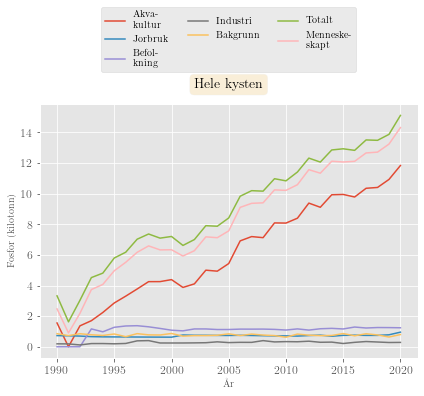

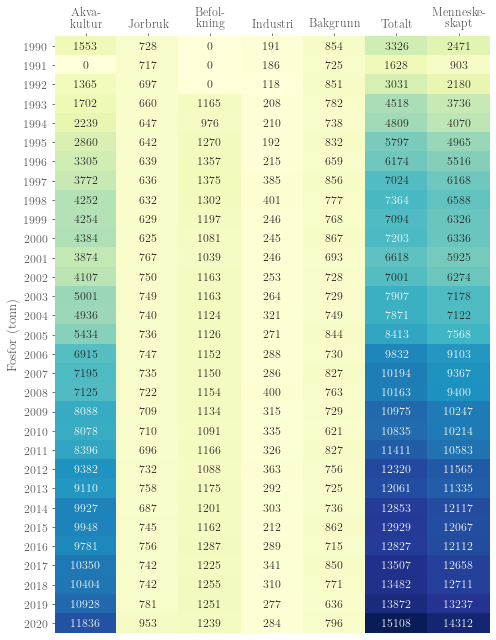

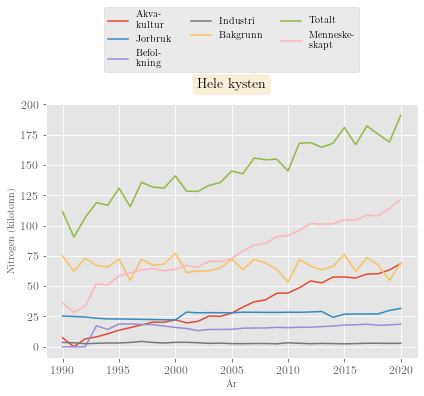

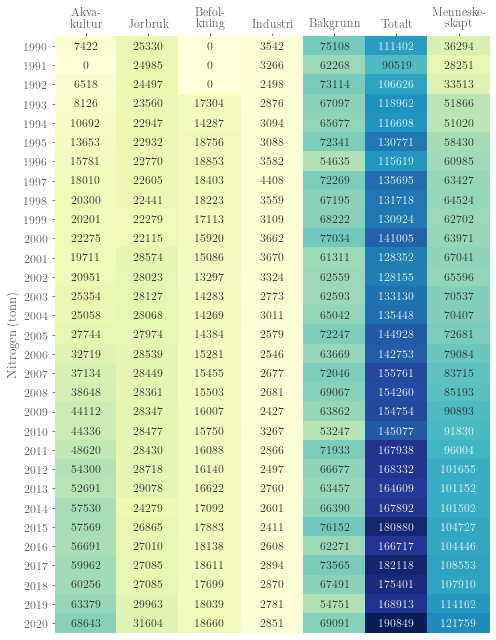

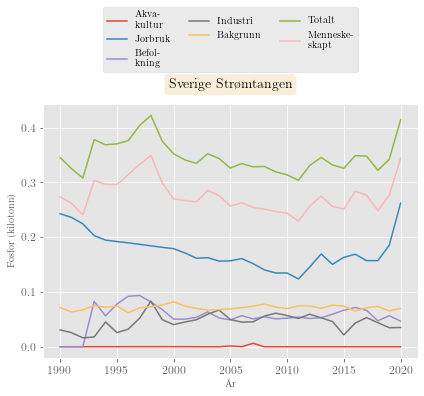

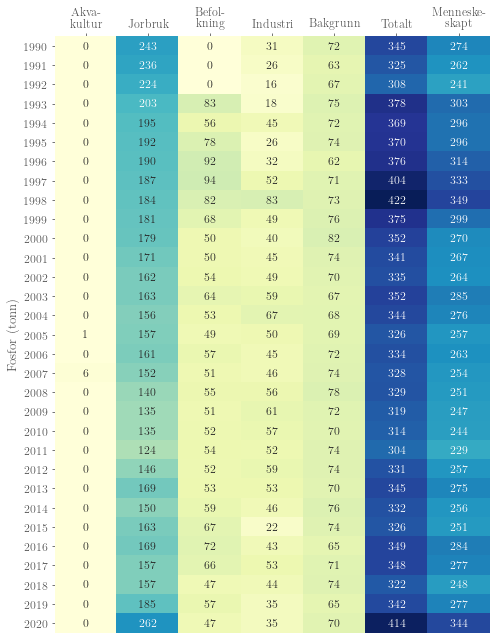

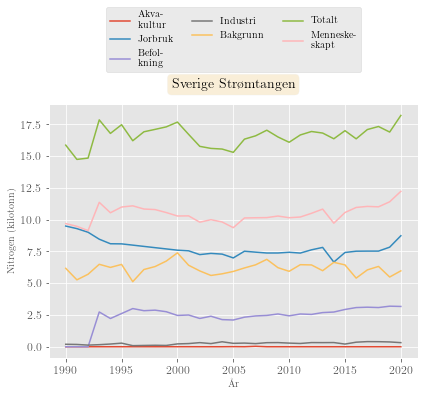

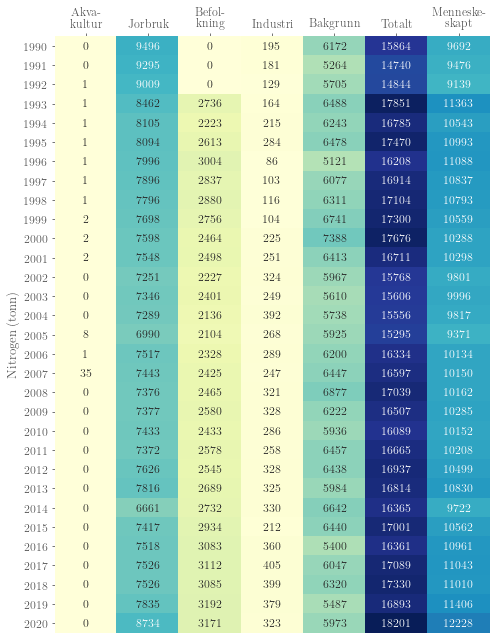

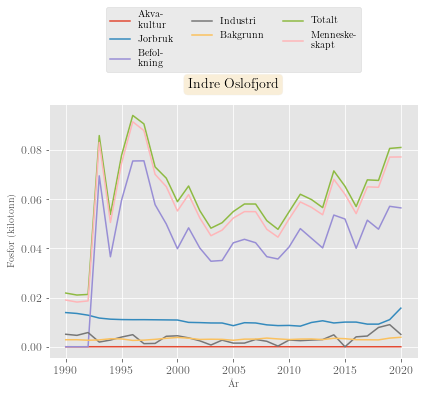

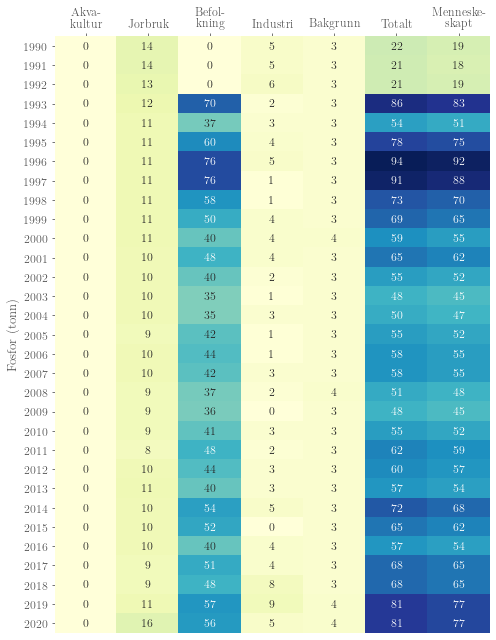

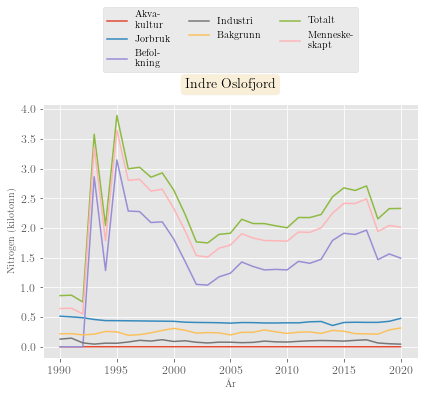

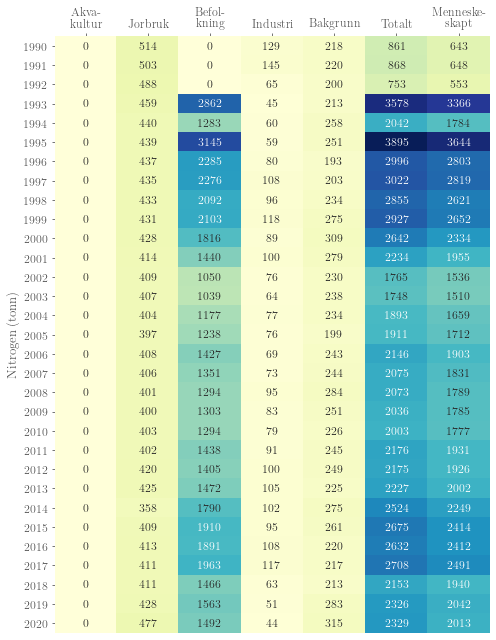

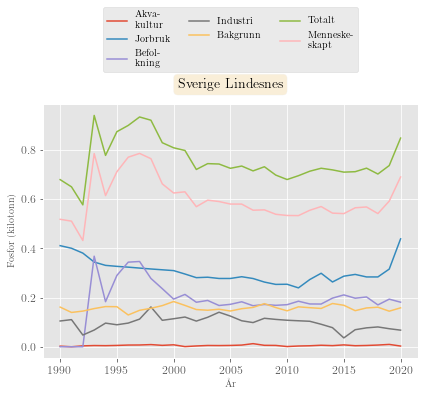

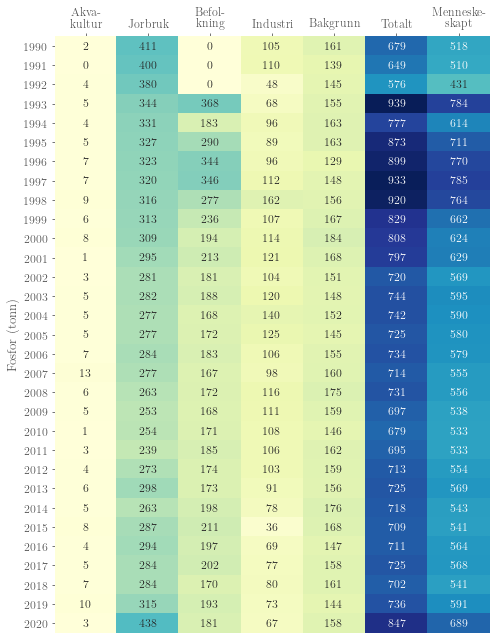

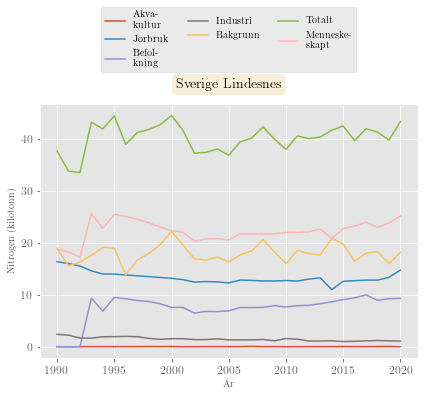

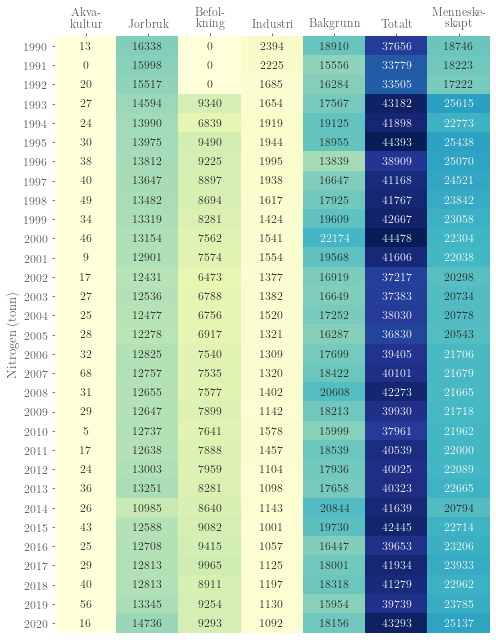

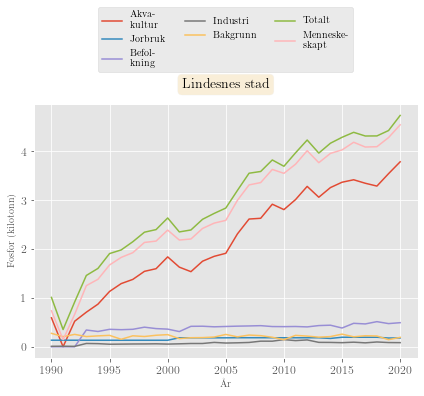

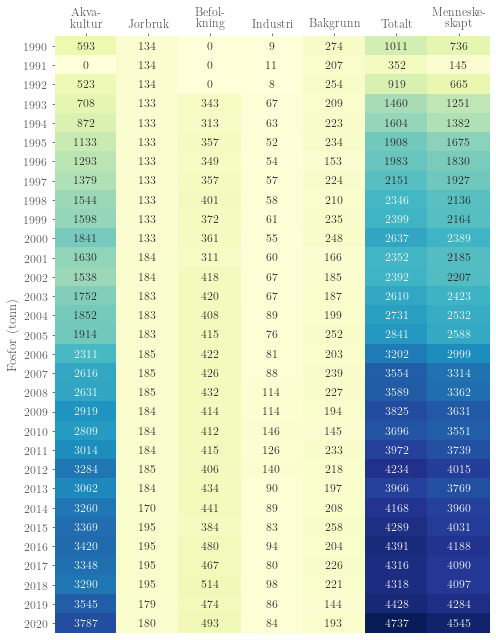

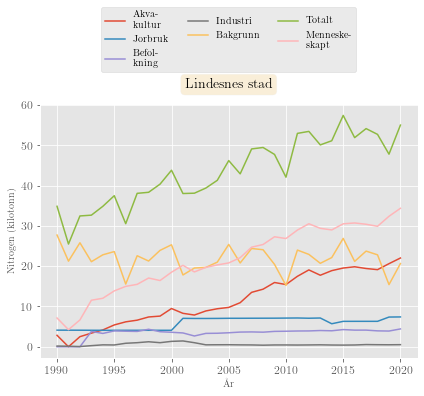

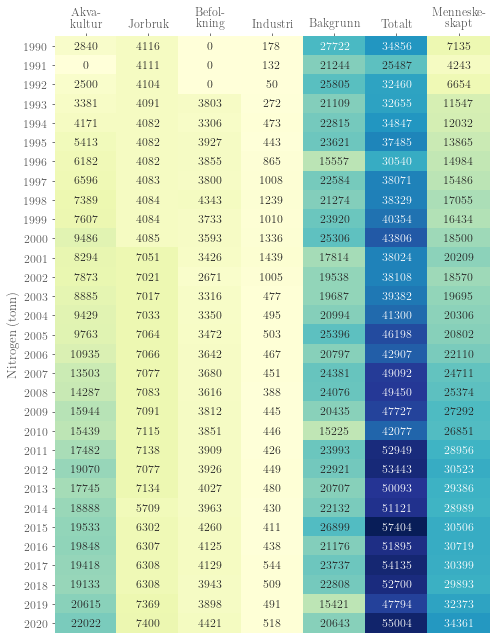

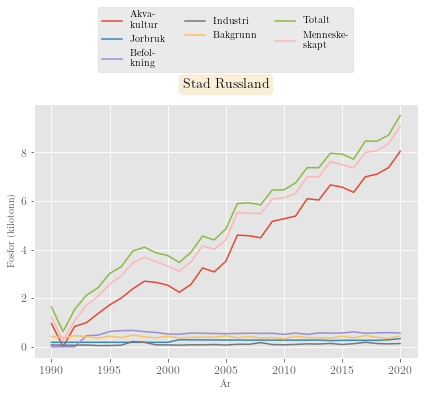

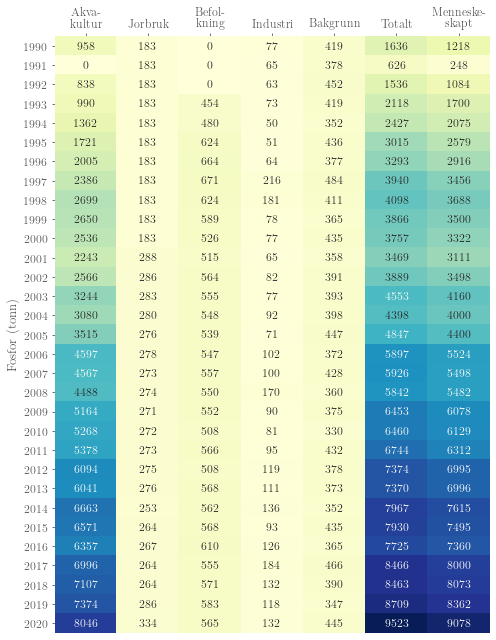

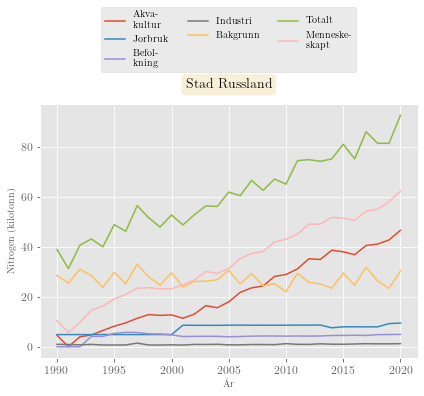

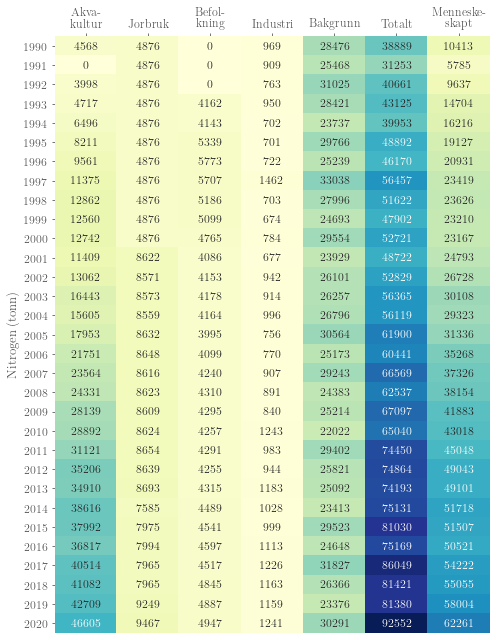

In [18]:
import matplotlib.pyplot as plt;
plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

latex_map = {'Hele kysten' : '''\subsection{{Norges kystområder, {} (tonn)}}''',
             'Sverige Strømtangen' : '''\subsection{{Sverige--Strømtangen fyr, {} (tonn)}}''',
             'Indre Oslofjord' : '''\subsection{{Indre Oslofjord, {} (tonn)}}''',
             'Sverige Lindesnes' : '''\subsection{{Svenskegrensa--Lindesnes, {} (tonn)}}''',
             'Lindesnes stad' : '''\subsection{{Lindesnes--Stad, {} (tonn)}}''',
             'Stad Russland' : '''\subsection{{Stad--Russland, {} (tonn)}}''',
            }

insertFig = '''

\\begin{{figure}}[H]
\includegraphics{{./Figures/{}}}
\end{{figure}}

'''
#[trim=10 10 15 40]
# def myplot(df,figname,key):
#     lbl = 'Nitrogen'
#     if figname.split('_')[-1] == 'p':
#         lbl = 'Fosfor'
    
#     (df.rename(columns = {'Bakgrun':'Bakgrunn'})/1000).plot(figsize=(8,5))
#     ax=plt.gca()
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#     ax.text(0.5, 1.08, key, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', horizontalalignment='center', bbox=props)
#     ax.set_ylabel('{} (kilotonn)'.format(lbl), fontsize='large', fontweight='bold')       
#     ax.set_xlabel('År', fontsize='large', fontweight='bold')
#     plt.legend(loc="upper center",fancybox=True,ncol=4,bbox_to_anchor=(0.5,1.4),fontsize='large')
#     plt.tick_params(axis='both', which='major', labelsize=12)
#     figpath = './Teotil/Latex//Figures/{}.png'.format(figname)
#     fig = plt.gcf()
#     fig.tight_layout()
#     plt.savefig(figpath)
def myplot(df,figname,key):
    lbl = 'Nitrogen'
    if figname.split('_')[-1] == 'p':
        lbl = 'Fosfor'
    
    (df.rename(columns = {'Bakgrun':'Bakgrunn'})/1000).plot(figsize=(6,6))
    ax=plt.gca()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.5, 1.1, key, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='center', bbox=props)
    ax.set_ylabel('{} (kilotonn)'.format(lbl), fontsize='medium', fontweight='bold')       
    ax.set_xlabel('År', fontsize='medium', fontweight='bold')
    plt.legend(loc="upper center",fancybox=True,ncol=3,bbox_to_anchor=(0.5,1.4),fontsize='medium')
    plt.tick_params(axis='both', which='major', labelsize=12)
    figpath = './Teotil/Latex/Figures/{}.png'.format(figname)
    fig = plt.gcf()
    fig.tight_layout()
    plt.savefig(figpath,dpi=600)
    

with open('./Teotil/Latex/tables_2021.tex','w') as f :
    for key in ['Hele kysten', 'Sverige Strømtangen','Indre Oslofjord','Sverige Lindesnes','Lindesnes stad','Stad Russland']:
        display(key)
        basename = key.replace(' ','_')
        f.write(latex_map[key].format('fosfor'))
        myplot(tables_p[key], basename + '_p',key)
        f.write('''\\begin{table}\n\centering\n''')
        f.write(tables_p[key].to_latex(float_format="%.0f"))
        plotTable(tables_p[key],'Fosfor (tonn)', key.replace(' ','_') + '_p.png')
        f.write('\end{table}\n')
        f.write(insertFig.format(basename + '_p'))
#         f.write("\\FloatBarrier\n")
        
        f.write(latex_map[key].format('nitrogen'))
        myplot(tables_n[key], basename + '_n',key)
        f.write('''\\begin{table}\n\centering\n''')
        f.write(tables_n[key].to_latex(float_format="%.0f"))
        plotTable(tables_n[key],'Nitrogen (tonn)', key.replace(' ','_') + '_n.png')
        f.write('\end{table}\n')
        f.write(insertFig.format(basename + '_n'))
#         f.write("\\FloatBarrier\n")
        
#Modifying table in tex file
with Connection('localhost') as c:
    c.local('''sed -i 's/{}.*\\\\/ \& Akva- \&  Jord- \&  Befol- \&  Indus- \&  Bak- \&  Totalt \& Menneske-\\\\\\\\/g' ./Teotil/Latex/tables_2021.tex''')
    c.local('''sed -i 's/År.*\\\\/År \& kultur \& bruk\&kning \&tri \&grunn \& \& skapt \\\\\\\\/g' ./Teotil/Latex/tables_2021.tex''')
    c.local('''sed -i  's/\\\\begin{table}/\\\\begin{table}\[H\]/g' ./Teotil/Latex/tables_2021.tex ''')

In [ ]:
latex_map = {'''Glomma''': '''\subsection{{Vannregion Glomma, {} (tonn)}}''',
             'Vest-Viken' : '''\subsection{{Vannregion Vest-Viken, {} (tonn)}}''',
             'Agder' : '''\subsection{{Vannregion Agder, {} (tonn)}}''',
             'Rogaland' : '''\subsection{{Vannregion Rogaland, {} (tonn)}}''',
             'Hordaland' : '''\subsection{{Vannregion Hordaland, {} (tonn)}}''',
             'Sogn og Fjordane' : '''\subsection{{Vannregion Sogn og Fjordane, {} (tonn)}}''',
             'Møre og Romsdal' : '''\subsection{{Vannregion Møre og Romsdal, {} (tonn)}}''',
             'Trøndelag' : '''\subsection{{Vannregion Trøndelag, {} (tonn)}}''',
             'Nordland' : '''\subsection{{Vannregion Nordland, {} (tonn)}}''',
             'Troms' : '''\subsection{{Vannregion Troms, {} (tonn)}}''',
             'Finnmark' : '''\subsection{{Vannregion Finnmark, {} (tonn)}}''',
            }

with open('./Teotil/Latex/norskevannregioner_2021.tex','w') as f :
    for key in latex_map.keys():
        basename = key.replace(' ','_')
#         f.write('\\clearpage\n')
        f.write(latex_map[key].format('fosfor'))
        f.write('\n')
        myplot(tables_p[key], basename + '_p',key)
        f.write('''\\begin{table}\n\centering\n''')
        f.write(tables_p[key].to_latex(float_format="%.0f"))
        plotTable(tables_p[key],'Fosfor (tonn)', key.replace(' ','_') + '_p.png')
        f.write('''\end{table}\n''')
        f.write(insertFig.format(basename + '_p'))
#         f.write("\\FloatBarrier\n")
        
#         f.write('\\clearpage\n')
        f.write(latex_map[key].format('nitrogen'))
        f.write('\n')
        myplot(tables_n[key], basename + '_n',key)
        f.write('''\\begin{table}\n\centering\n''')
        f.write(tables_n[key].to_latex(float_format="%.0f"))
        plotTable(tables_n[key],'Nitrogen (tonn)', key.replace(' ','_') + '_n.png')
        f.write('''\end{table}\n''')
        f.write(insertFig.format(basename + '_n'))
        
#         f.write("\\FloatBarrier\n")
        
#Modifying table in tex file
with Connection('localhost') as c:
    c.local('''sed -i 's/{}.*\\\\/ \& Akva- \&  Jord- \&  Befol- \&  Indus- \&  Bak- \&  Totalt \& Menneske-\\\\\\\\/g' ./Teotil/Latex/norskevannregioner_2020.tex''')
    c.local('''sed -i 's/År.*\\\\/År \& kultur \& bruk\&kning \&tri \&grunn \& \& skapt \\\\\\\\/g' ./Teotil/Latex/norskevannregioner_2020.tex''')
    c.local('''sed -i  's/\\\\begin{table}/\\\\begin{table}\[H\]/g' ./Teotil/Latex/norskevannregioner_2020.tex ''')
insertMap = '''

\\begin{{figure}}[H]
\includegraphics{{/home/jose-luis/dummy/{}}}
\end{{figure}}

'''
    
with open('./Teotil/Latex/norskevannregioner_2021.tex','a') as f :
    f.write('\\clearpage\n')
    f.write('''\\subsection{Kartpresentasjon av tilførsler av næeringssalter till sjø fra vannregionene}''')
    f.write(insertMap.format('vannregion_fosfor'))
    f.write(insertMap.format('vannregion_nitrogen'))

In [ ]:
latex_map = {'''Nordsjøen''': '''\subsection{{Nordsjøen, {} (tonn)}}''',
             'Norskehav' : '''\subsection{{Norskehavet, {} (tonn)}}''',
             'Barentshavet' : '''\subsection{{Barentshavet, {} (tonn)}}'''
            }

with open('./Teotil/Latex/norskehav_2021.tex','w') as f :
    for key in latex_map.keys():
        basename = key.replace(' ','_')
#         f.write('\\clearpage\n')
        f.write(latex_map[key].format('fosfor'))
        myplot(tables_p[key], basename + '_p',key)
        f.write('''\\begin{table}\n\centering\n''')
        f.write(tables_p[key].to_latex(float_format="%.0f"))
        plotTable(tables_p[key],'Fosfor (tonn)', key.replace(' ','_') + '_p.png')
        f.write('\end{table}\n')
        f.write(insertFig.format(basename + '_p'))
#         f.write("\\FloatBarrier\n")
        
#         f.write('\\clearpage\n')
        f.write(latex_map[key].format('nitrogen'))
        myplot(tables_n[key], basename + '_n',key)
        f.write('''\\begin{table}\n\centering\n''')
        f.write(tables_n[key].to_latex(float_format="%.0f"))
        plotTable(tables_n[key],'Nitrogen (tonn)', key.replace(' ','_') + '_n.png')
        f.write('\end{table}\n')
        f.write(insertFig.format(basename + '_n'))
#         f.write("\\FloatBarrier\n")
        
#Modifying table in tex file
with Connection('localhost') as c:
    c.local('''sed -i 's/{}.*\\\\/ \& Akva- \&  Jord- \&  Befol- \&  Indus- \&  Bak- \&  Totalt \& Menneske-\\\\\\\\/g' ./Teotil/Latex/norskehav_2020.tex''')
    c.local('''sed -i 's/År.*\\\\/År \& kultur \& bruk\&kning \&tri \&grunn \& \& skapt \\\\\\\\/g' ./Teotil/Latex/norskehav_2020.tex''')
    c.local('''sed -i  's/\\\\begin{table}/\\\\begin{table}\[H\]/g' ./Teotil/Latex/norskehav_2020.tex ''')


with open('./Teotil/Latex/norskehav_2021.tex','a') as f :
#     f.write('\\clearpage\n')
    f.write('''\\subsection{Kartpresentasjon av tilførsler av næeringssalter forvaltingsplanområder}''')
    f.write(insertMap.format('vannregion_fosfor_hav'))
    f.write(insertMap.format('vannregion_nitrogen_hav'))


In [19]:
for file in allResults[:1]:
    file = file.replace('blob','raw')
    year=int(file.split('.')[1][-4:])
    display(year)
    with Connection('localhost') as c:
        c.local('wget -O {}.csv {}'.format(year,file),hide='stderr')
    df = pd.read_csv('{}.csv'.format(year))
    df.set_index('regine_ned',inplace=True)
    df = df.filter(regex='\.$',axis=0)
    df.set_index(map(int,map(float,df.index.values)),inplace=True)

    to_db = {}
    for key in teotil_report_map_p.keys() : 
    #     display(key)
        to_db[key]  = df[teotil_report_map_p[key]].sum(axis=1).rename(key)


    df = pd.concat([to_db['Akvakultur'], to_db['Jordbruk'],to_db['Befolkning'], to_db['Industri'],to_db['Bakgrunn'], to_db['Totalt'],to_db['Menneskeskapt'], to_db['Urban']],  sort=False,axis=1)
    df['sum'] = df['Totalt'] - df['Urban']
    df['antrop'] =  df['Totalt'] - df['Urban'] - df['Bakgrunn']

    # display(df)

    for i,j in df.iterrows() : 
        query('''insert into {schema}.t_fosfor(vassomr,id_num,year,akva,jordbr,befolkn,ind,natur,sum,antrop) values ({}, {},{},{},{},{}, {},{},{},{});'''.format(
        i,i,year,
        j['Akvakultur'],
        j['Jordbruk'],
        j['Befolkning'],
        j['Industri'],
        j['Bakgrunn'],
        j['sum'],
        j['antrop'],
        schema=schema),fetch=False)
        
    
    df = pd.read_csv('{}.csv'.format(year))
    df.set_index('regine_ned',inplace=True)
    df = df.filter(regex='\.$',axis=0)
    df.set_index(map(int,map(float,df.index.values)),inplace=True)
        
    to_db = {}
    for key in teotil_report_map_p.keys() : 
         to_db[key]  = df[teotil_report_map_n[key]].sum(axis=1).rename(key)


    df = pd.concat([to_db['Akvakultur'], to_db['Jordbruk'],to_db['Befolkning'], to_db['Industri'],to_db['Bakgrunn'], to_db['Totalt'],to_db['Menneskeskapt'], to_db['Urban']],  sort=False,axis=1)
    df['sum'] = df['Totalt'] - df['Urban']
    df['antrop'] =  df['Totalt'] - df['Urban'] - df['Bakgrunn']

1990

In [22]:
df

,Akvakultur,Jordbruk,Befolkning,Industri,Bakgrunn,Totalt,Menneskeskapt,Urban,sum,antrop
315,0.000000,0.000000,0.0,0.00000,0.378178,0.378178,0.000000,0.000000,0.378178,0.000000
314,0.000000,20.842638,0.0,0.00000,79.535511,100.378148,20.842638,0.000000,100.378148,20.842638
313,0.000000,225.204322,0.0,0.00000,193.140642,418.344964,225.204322,0.000000,418.344964,225.204322
312,0.000000,0.000000,0.0,0.00000,72.115872,72.115872,0.000000,0.000000,72.115872,0.000000
311,0.000000,11.210132,0.0,0.00000,651.192914,662.403046,11.210132,0.000000,662.403046,11.210132
...,...,...,...,...,...,...,...,...,...,...
5,0.000000,223.561289,0.0,0.00000,49.874848,280.249171,230.374323,6.813034,273.436137,223.561289
4,0.000000,306.706014,0.0,0.00000,58.168288,368.135422,309.967134,3.261120,364.874302,306.706014
3,0.000000,405.513993,0.0,51.00000,172.140560,636.556679,464.416119,7.902126,628.654553,456.513993
2,0.413678,8985.890175,0.0,133.42484,5796.362996,14999.040091,9202.677095,82.948402,14916.091689,9119.728693
